In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

In [65]:
#user-defined parameters

quantile_thresh = 0.999  # the percentile to consider [0.995]
time_res='1H'            #the time resoltuion at which to perfrom the analysis ['1H']
n_categories = 4         # number of categories for V, B [4]. 4 = quartiles, etc
n_cl_bins = 100          # number of cost/loss bins for plotting  [100]

99.9th percentile of G: 0.1174


Text(0, 0.5, 'Geoeffectiveness')

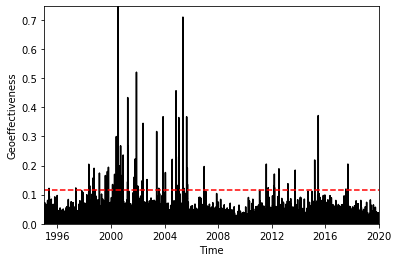

In [70]:
#Load and process data
######################
def load_omni(): 
    columns = ['date', 'time', 'hgi_lat', 'hgi_lon', 'br', 'bt', 'bn', 'b', 'v', 'v_lat', 'v_lon', 'density', 'temperature']
    omni = pd.read_csv('OMNI_COHO1HR_MERGED_MAG_PLASMA_199207.txt', delim_whitespace=True, skiprows=240, skipfooter=3, names=columns, engine='python')
    # Combine date and time into timeindex
    omni['time'] = pd.to_datetime(omni['date']+'T'+omni['time'], format='%d-%m-%YT%H:%M:%S.%f')
    omni.drop(columns='date', inplace=True)
    
    omni.set_index('time', inplace=True)

    # Set invalid numbers to NaN
    id_bad = omni == -1e31
    omni[id_bad] = np.NaN
    return omni

def load_icme():
    """
    Function to load in the Richardson and Cane ICME list.
    """
    columns = ['shock', 'leading_edge', 'trailing_edge', 'type']
    icme = pd.read_csv('ICMEs.dat', delim_whitespace=True, names=columns)
    
    # Convert MJD to datetimes.
    icme['shock'] = pd.to_datetime(Time(icme['shock'], format='mjd').datetime)
    icme['leading_edge'] = pd.to_datetime(Time(icme['leading_edge'], format='mjd').datetime)
    icme['trailing_edge'] = pd.to_datetime(Time(icme['trailing_edge'], format='mjd').datetime)
    
    return icme

def cumdf(data, bin_edges):
    hist, bins = np.histogram(data, bins=bin_edges)
    cdf = np.cumsum(hist) / np.sum(hist)
    return cdf

omni = load_omni()
icme = load_icme()

#resample the omni data at the required resolution
omni=omni.resample(time_res).mean()

# Remove rows from omni with any bad speed, density or imf magnitude data (all needed for G calculaiton)
#omni.dropna(how='any', subset=['density', 'v', 'b'], inplace=True)

# compute geoeffectivness parameter
alpha=0.5;
# IMF clock angle
theta=np.arctan2(-omni['bt'],omni['bn']);
# Equation 1 in Owens et al. 2017
d_exp = 2.0/3.0 - alpha
b_exp = 2.0*alpha
v_exp = 7.0/3.0 - 2.0*alpha
omni['g'] = (omni['density']**d_exp) * (omni['b']**b_exp) * (omni['v']**v_exp) * (np.sin(theta/2.0)**4.0) * 1e-6


g_thresh = np.nanquantile(omni['g'], quantile_thresh)
print("{:3.1f}th percentile of G: {:3.4f}".format(quantile_thresh*100.0,g_thresh))

plt.plot(omni['g'], 'k-', zorder=0)
plt.hlines(g_thresh, omni.index.min(), omni.index.max(), colors='r', linestyles='--', zorder=1)
plt.xlim(omni.index.min(), omni.index.max())
plt.ylim(0, omni['g'].max())
plt.xlabel('Time')
plt.ylabel('Geoeffectiveness')


In [ ]:
# Compute the quantiles of the CME speed distribution
n_bins = 10000  # number of bins for CDF [10000]

# Define G bins for computing CDFs
g_min = omni['g'].min()
g_max = omni['g'].max()
dg = (g_max-g_min)/n_bins
g_bin_edges = np.arange(g_min, g_max+dg, dg)
g_bin_centres = (g_bin_edges[0:-1] + g_bin_edges[1:]) / 2.0


# Loop through the ICMEs and compute the average CME properties, and also mask the solar wind time series.
# Add in keys to icme and omni for the average solar wind properties and cme properties.
for key in ['v', 'b']:
    icme[key] = np.NaN*np.zeros(icme.shape[0])
    
for key in ['cme_v', 'cme_b', 'region', 'type']:
    if key not in ['region', 'type']:
        omni[key] = np.NaN*np.zeros(omni.shape[0])
    else:
        omni[key] = np.zeros(omni.shape[0])
    
for i, row in icme.iterrows():
    
    # Find solar wind period between cme shock and trailing edge
    id_cme = (omni.index >= row['shock']) & (omni.index <= row['trailing_edge'])
    if np.any(id_cme):
        # Update ICME with solar wind parameters
        icme.loc[i, 'v'] = omni.loc[id_cme, 'v'].mean(skipna=True) 
        icme.loc[i, 'b'] = omni.loc[id_cme, 'b'].mean(skipna=True) 
        
        # Update solar wind paramters with average CME properties and type
        omni.loc[id_cme, 'cme_v'] = icme.loc[i, 'v']
        omni.loc[id_cme, 'cme_b'] = icme.loc[i, 'b']
        omni.loc[id_cme, 'region'] = 1 # Flag for being in sheath, will update CME regions after.
        omni.loc[id_cme, 'type'] = icme.loc[i, 'type']
     
    # Update region flag if in CME rather than sheath
    id_cme = (omni.index >= row['leading_edge']) & (omni.index <= row['trailing_edge'])
    if np.any(id_cme):
        omni.loc[id_cme, 'region'] = 2


In [ ]:
#Compute the G values for each CME quantile

quantiles = np.arange(1, n_categories, 1) / n_categories
v_quantiles = icme['v'].quantile(quantiles)
b_quantiles = icme['b'].quantile(quantiles)

print('V quantile boundaries are: ',v_quantiles)
print('B quantile boundaries are: ',b_quantiles)

# Find the indices of SW parameters for the different v and b quantiles and sw classifications (cme, no cme)
groups = {}
groups['all'] = np.argwhere(np.isfinite(omni['g'])).squeeze()
groups['no_cme'] = np.argwhere(omni['region'] == 0).squeeze()
groups['cme'] = np.argwhere(omni['region'] > 0).squeeze()

for i in range(v_quantiles.size + 1):
    
    v_key = "v_{:02d}".format(i)
    b_key = "b_{:02d}".format(i)
    if i == 0:
        id_group = omni['cme_v'] <= v_quantiles.values[i] # do nans need to be exlucded here?
        groups[v_key] = np.argwhere(id_group).squeeze()
        
        id_group = omni['cme_b'] <= b_quantiles.values[i]
        groups[b_key] = np.argwhere(id_group).squeeze()
        
    elif (i > 0) & (i < v_quantiles.size):
        id_group = (omni['cme_v'] > v_quantiles.values[i-1]) & (omni['cme_v'] <= v_quantiles.values[i])
        groups[v_key] = np.argwhere(id_group).squeeze()
        
        id_group = (omni['cme_b'] > b_quantiles.values[i-1]) & (omni['cme_b'] <= b_quantiles.values[i])
        groups[b_key] = np.argwhere(id_group).squeeze()
    
    elif i == v_quantiles.size:
        id_group = omni['cme_v'] > v_quantiles.values[i-1]
        groups[v_key] = np.argwhere(id_group).squeeze()
        
        id_group = omni['cme_b'] > b_quantiles.values[i-1]
        groups[b_key] = np.argwhere(id_group).squeeze()
        
# Now the combined V and B groups
for i in range(v_quantiles.size + 1):
    v_key = "v_{:02d}".format(i)
    
    for j in range(b_quantiles.size + 1):
        b_key = "b_{:02d}".format(j)
        vb_key = v_key + '_' + b_key
        # Also get the intersection of the matched quantiles for the combined v-b category
        groups[vb_key] = np.intersect1d(groups[v_key], groups[b_key])

In [ ]:
# Compute the exceedance probability and numbers above and below threshold for each grouping of the data.
prob = {}
number = {}

# Find g_bin closest to threshold from below.
pos = np.argwhere(g_bin_centres <= g_thresh).squeeze() # should this be <=?
id_exceed = pos[-1]
for key, index in groups.items():
    
    g_sub = omni.iloc[index]['g']
    cdf = cumdf(g_sub, g_bin_edges)
    prob[key] = 1.0 - cdf[id_exceed]
    n_above = np.sum(g_sub > g_thresh)
    n_below = np.sum(g_sub <= g_thresh)
    n_all = np.sum(np.isfinite(g_sub))
    number[key] = {'above': n_above, 'below': n_below, 'all': n_all}
    


In [ ]:
# Ouput key statistics
print("Ncme = {}, Ncme' = {}".format(number['cme']['all'], number['cme']['above']))
print("Nsw = {}, Nsw' = {}".format(number['no_cme']['all'], number['no_cme']['above']))
print("p'sw = {:3.4f}".format(number['no_cme']['above']/number['no_cme']['all']))
print("p'cme = {:3.4f}".format(number['cme']['above']/number['cme']['all']))

In [ ]:
#Perform cost/loss analysis
costs = np.geomspace(0.001, 1, num=n_cl_bins)

# DataFrame to store all cost calculations
costloss = pd.DataFrame({'cost':costs, 'perfect': 0, 'climatology': 0, 'cmes': 0, 'v': 0, 'b': 0, 'vb': 0})
loss = 1.0
for i, cost in enumerate(costs):
    
    # cost of a perfect deterministic forecast is the number of times the
    # threshold is exceeded, multiplied by the cost
    costloss.loc[i, 'perfect'] = cost * number['all']['above']
    
    # cost of climatology is different if the climatological probability is
    # above or below the c/l ratio
    if (cost <= prob['all']):  # always take action
        # cost is the clratio at all times
        costloss.loc[i, 'climatology'] = cost * number['all']['all']   
    elif (cost > prob['all']): #never take action
        # cost is simply all the missed events
        costloss.loc[i, 'climatology'] = loss * number['all']['above']
        
    ##########################
    # Update the costs due to no_cme solar wind
    if cost <= prob['no_cme']:
        costloss.loc[i, 'cmes'] = cost * number['no_cme']['all']
        costloss.loc[i, 'v'] = cost * number['no_cme']['all']
        costloss.loc[i, 'b'] = cost * number['no_cme']['all']
        costloss.loc[i, 'vb'] = cost * number['no_cme']['all']     
        
    elif cost > prob['no_cme']:
        costloss.loc[i, 'cmes'] = loss * number['no_cme']['above']
        costloss.loc[i, 'v'] = loss * number['no_cme']['above']
        costloss.loc[i, 'b'] = loss * number['no_cme']['above']
        costloss.loc[i, 'vb'] = loss * number['no_cme']['above']
        
    ##########################
    # Update the costs due to icme arrivals
    if cost <= prob['cme']:
        costloss.loc[i, 'cmes'] += cost * number['cme']['all']
    elif cost > prob['cme']:
        costloss.loc[i, 'cmes'] += loss * number['cme']['above']
        
    ##########################
    # Update the costs due to v & b categories
    for j in range(v_quantiles.size + 1):
        v_key = "v_{:02d}".format(j)
        b_key = "b_{:02d}".format(j)
        
        if cost <= prob[v_key]:
            costloss.loc[i, 'v'] += cost * number[v_key]['all']
        elif cost > prob[v_key]:
            costloss.loc[i, 'v'] += loss * number[v_key]['above']
            
        if cost <= prob[b_key]:
            costloss.loc[i, 'b'] += cost * number[b_key]['all']
        elif cost > prob[v_key]:
            costloss.loc[i, 'b'] += loss * number[b_key]['above']
            
    ##########################
    # Update the costs due to combined v & b categories
    for j in range(v_quantiles.size + 1):
        v_key = "v_{:02d}".format(j)
        for k in range(b_quantiles.size + 1):
            b_key = "b_{:02d}".format(k)
            vb_key = v_key + '_' + b_key

            if cost <= prob[vb_key]:
                costloss.loc[i, 'vb'] += cost * number[vb_key]['all']
            elif cost > prob[vb_key]:
                costloss.loc[i, 'vb'] += loss * number[vb_key]['above']

# Compute the relative forecast value (clim - forecast)/(clim - perfect)
for key in ['cmes', 'v', 'b', 'vb']:
    new_key = key+"_relative"
    costloss[new_key] = 100 * (costloss['climatology'] - costloss[key]) / (costloss['climatology'] - costloss['perfect'])

In [ ]:
#plot the cost-loss summary    
fig, ax = plt.subplots(figsize=(8,6))
ax.fill_between(costloss['cost'], 0, costloss['cmes_relative'], color=[0.7, 0.7, 0.7], label='ICME Arrival time only')
ax.plot(costloss['cost'], costloss['v_relative'], 'b-', label='+ ICME V')
ax.plot(costloss['cost'], costloss['b_relative'], 'r-', label='+ ICME B')
ax.plot(costloss['cost'], costloss['vb_relative'], 'k-', label='+ ICME V & B')

ax.set_xscale('log')
#ax.set_ylim(0, 70)
ax.set_xticks((0.001,0.01,0.1,1))
ax.set_xticklabels(('0.001','0.01','0.1','1'))
ax.set_xlim(0.001, 1.0)
#legend
handles, labels = plt.gca().get_legend_handles_labels()
legendorder = [3,0,1,2]
plt.legend([handles[idx] for idx in legendorder],[labels[idx] for idx in legendorder])

ax.grid(b=True, which='both', axis='both')
ax.set_ylabel('Forecast value (%)')
ax.set_xlabel('C/L: Relative cost of taking mitigating action')

ax.annotate('', xy=(0.75, 1.1), xycoords='axes fraction', xytext=(1, 1.1), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.annotate('False alarms\ncannot be tolerated', xy=(0.8, 1.1), xycoords='axes fraction', xytext=(0.52, 1.04),ha='left' )

ax.annotate('', xy=(0.225, 1.1), xycoords='axes fraction', xytext=(0, 1.1), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.annotate('False alarms\ncan be tolerated', xy=(0.8, 1.1), xycoords='axes fraction', xytext=(0.45, 1.04),ha='right' )